In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score

In [3]:
from data.utils import add_experience, feature_classification, astype_category

In [4]:
# DataFrame 초기 세팅
hr_df = pd.read_csv(Path.cwd() / 'data' / 'HR-Employee-Attrition.csv')
hr_df = (hr_df
         .pipe(add_experience)
         .pipe(feature_classification, return_dataframe=True)
         .pipe(astype_category)
         .set_index('EmployeeNumber')
)
hr_df = (hr_df
         .assign(Attrition=lambda df: df['Attrition'].replace({'Yes':1, 'No':0}))
         .assign(OverTime=lambda df: df['OverTime'].replace({'Yes':1, 'No':0}))
)
hr_df.columns

Index(['MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'Age',
       'Gender', 'MaritalStatus', 'Education', 'EducationField',
       'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
       'Experienced', 'Department', 'BusinessTravel', 'JobLevel', 'JobRole',
       'JobInvolvement', 'OverTime', 'WorkLifeBalance',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'PerformanceRating',
       'RelationshipSatisfaction', 'Attrition'],
      dtype='object')

In [5]:
# 필요 내용 category 변경 확인
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   MonthlyIncome             1470 non-null   int64   
 1   PercentSalaryHike         1470 non-null   int64   
 2   StockOptionLevel          1470 non-null   int64   
 3   Age                       1470 non-null   int64   
 4   Gender                    1470 non-null   category
 5   MaritalStatus             1470 non-null   category
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   category
 8   DistanceFromHome          1470 non-null   int64   
 9   NumCompaniesWorked        1470 non-null   int64   
 10  TotalWorkingYears         1470 non-null   int64   
 11  Experienced               1470 non-null   category
 12  Department                1470 non-null   category
 13  BusinessTravel            1470 non-null   catego

In [6]:
# categorical variables에 대한 one-hot encoding
hr_df_onehot = pd.get_dummies(hr_df, columns=['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction',
                                              'Experienced', 'Gender', 'JobRole', 'MaritalStatus'])
hr_df_onehot

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,5993,11,0,41,1,8,8,2,3,1,...,0,0,0,0,0,1,0,0,0,1
2,5130,23,1,49,8,1,10,2,2,0,...,0,0,0,0,1,0,0,0,1,0
4,2090,15,0,37,2,6,7,1,2,1,...,1,0,0,0,0,0,0,0,0,1
5,2909,11,0,33,3,1,8,1,3,1,...,0,0,0,0,1,0,0,0,1,0
7,3468,12,1,27,2,9,6,1,3,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571,17,1,36,23,4,17,2,4,0,...,1,0,0,0,0,0,0,0,1,0
2062,9991,15,1,39,6,4,9,3,2,0,...,0,0,0,0,0,0,0,0,1,0
2064,6142,20,1,27,4,1,6,2,4,1,...,0,0,1,0,0,0,0,0,1,0


In [7]:
X = hr_df_onehot.drop('Attrition', axis=1)
y = hr_df_onehot['Attrition']
X.shape, y.shape

((1470, 57), (1470,))

In [20]:
# PolynomialFeatures는 각 요소들의 결합만 확인하도록 interaction_only 진행
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False).fit(X)
X_poly = poly.transform(X)

In [22]:
# X_poly를 DataFrame으로 변환 → Columns가 30,913개로 많으므로 조치 필요
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out())
X_poly

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_Sales Executive JobRole_Sales Representative MaritalStatus_Divorced,JobRole_Sales Executive JobRole_Sales Representative MaritalStatus_Married,JobRole_Sales Executive JobRole_Sales Representative MaritalStatus_Single,JobRole_Sales Executive MaritalStatus_Divorced MaritalStatus_Married,JobRole_Sales Executive MaritalStatus_Divorced MaritalStatus_Single,JobRole_Sales Executive MaritalStatus_Married MaritalStatus_Single,JobRole_Sales Representative MaritalStatus_Divorced MaritalStatus_Married,JobRole_Sales Representative MaritalStatus_Divorced MaritalStatus_Single,JobRole_Sales Representative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single
0,5993.0,11.0,0.0,41.0,1.0,8.0,8.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2090.0,15.0,0.0,37.0,2.0,6.0,7.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1468,5390.0,14.0,0.0,49.0,2.0,2.0,17.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# 재직 중인 인원들만 대상으로 실제 test를 수행하기 위해 재직 인원들만 query 진행
# y를 다시 합칠 때 index가 맞춰져있어야 하므로 해당 작업 수행
X_attr_no = (X_poly
             .assign(EmpNum=X.index)
             .set_index('EmpNum')
             .assign(Attrition=y)
             .query("Attrition == 0")
)
X_attr_no

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_Sales Executive JobRole_Sales Representative MaritalStatus_Married,JobRole_Sales Executive JobRole_Sales Representative MaritalStatus_Single,JobRole_Sales Executive MaritalStatus_Divorced MaritalStatus_Married,JobRole_Sales Executive MaritalStatus_Divorced MaritalStatus_Single,JobRole_Sales Executive MaritalStatus_Married MaritalStatus_Single,JobRole_Sales Representative MaritalStatus_Divorced MaritalStatus_Married,JobRole_Sales Representative MaritalStatus_Divorced MaritalStatus_Single,JobRole_Sales Representative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single,Attrition
EmpNum,,,,,,,,,,,,,,,,,,,,,
2,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,3068.0,13.0,0.0,32.0,2.0,0.0,8.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,2670.0,20.0,3.0,59.0,3.0,4.0,12.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2062,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2064,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [30]:
# train set과 test set 구분
# 참고 : 여기서는 좀 더 정확하게 dataset 구분 후 StandardScaler 진행 예정
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1102, 30913), (368, 30913), (1102,), (368,))

In [32]:
# StandardScaler 수행
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [49]:
# LogisticRegression 수행
# Features가 많으므로 L1 Regularization 진행하고 Regularization의 강도를 높이는 형태
# Baseline보다 더 높은 roc_auc_score를 보여줌
logreg = LogisticRegression(max_iter=1000, C=0.03, penalty='l1', solver='liblinear').fit(X_train_sc, y_train)
logreg.score(X_test_sc, y_test), roc_auc_score(y_test, logreg.predict_proba(X_test_sc)[:, 1])

(0.8532608695652174, 0.792547274749722)

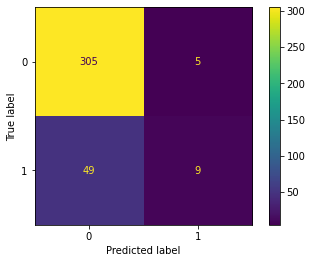

In [50]:
# confusion matrix는 다소 불만족스러우나, roc_auc_score가 높으므로 predict probability 조정 가능
ConfusionMatrixDisplay.from_predictions(y_test, logreg.predict(X_test_sc))